In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:01<00:00, 44.2MB/s]
100% 60.3M/60.3M [00:02<00:00, 31.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import cv2
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [5]:
# Directory paths
train_dir = "/content/train/"
test_dir = "/content/test/"


In [6]:
# Function to count classes
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df


<Axes: >

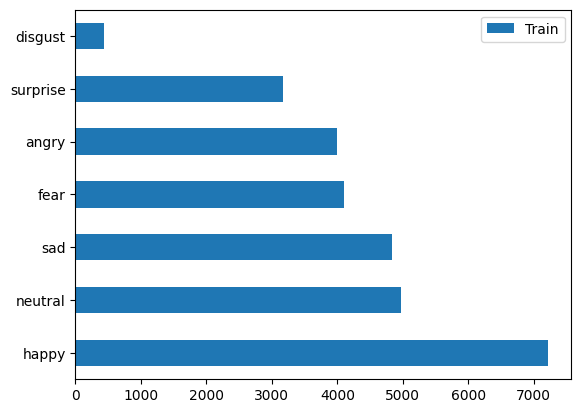

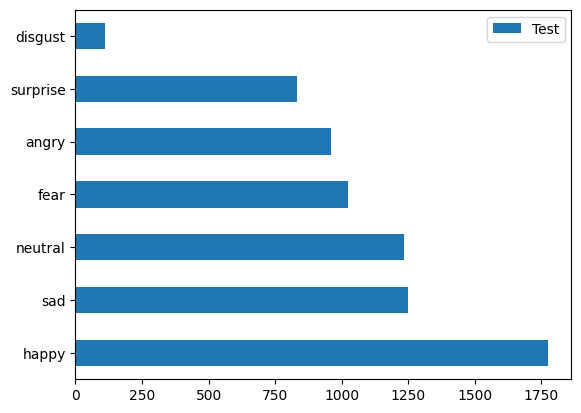

In [7]:
# Counting classes
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

pd.concat([Train_Count, Test_Count], axis=1)
Train_Count.plot(kind='barh')
Test_Count.plot(kind='barh')


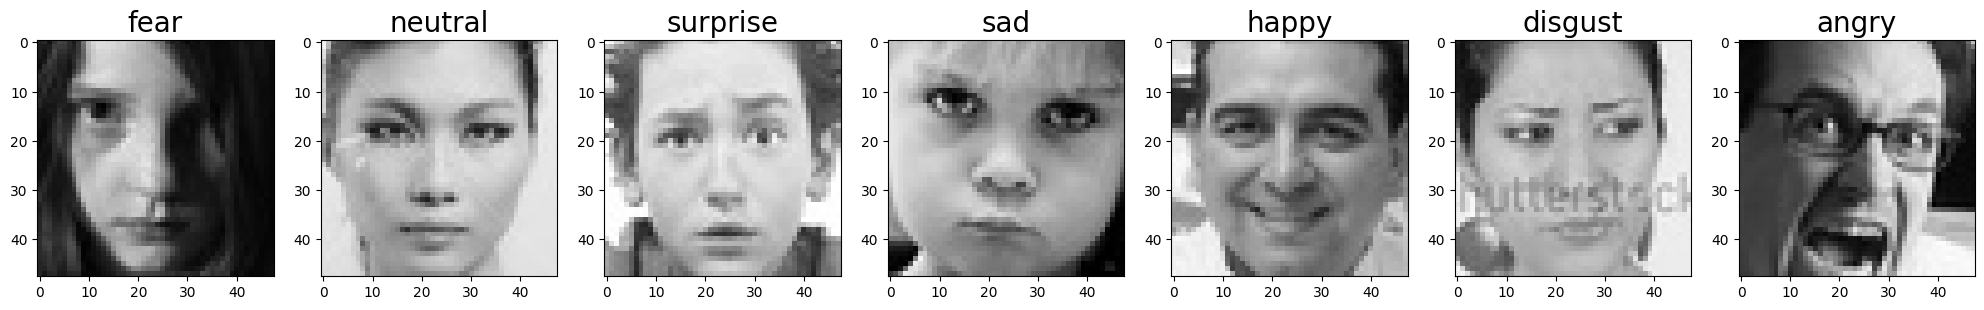

In [8]:
# Displaying sample images
plt.style.use('default')
plt.figure(figsize=(25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)


In [9]:
# Image pre-processing and augmentation
img_shape = 224
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

train_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# Load VGG16 model, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Define VGG16-based model
def Create_VGG16_Model():
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

VGG16_Model = Create_VGG16_Model()
VGG16_Model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 21139271 (80.64 MB)
Trainable params: 13504007 (51.51 MB)
Non-trainable params: 7635264 (29.13 MB)
__________

In [11]:
# Compile the model
VGG16_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Define callbacks
checkpoint_path = "VGG16_Model_Checkpoint"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]


In [13]:
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

# Train the model
VGG16_history = VGG16_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/15
448/448 [==============================] - 449s 966ms/step - loss: 1.8361 - accuracy: 0.2504 - val_loss: 1.6907 - val_accuracy: 0.3015 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - 438s 978ms/step - loss: 1.5331 - accuracy: 0.4017 - val_loss: 1.3902 - val_accuracy: 0.4607 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - 422s 940ms/step - loss: 1.4201 - accuracy: 0.4492 - val_loss: 1.3380 - val_accuracy: 0.4789 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - 424s 947ms/step - loss: 1.3557 - accuracy: 0.4774 - val_loss: 1.2830 - val_accuracy: 0.4987 - lr: 0.0010
Epoch 5/15
448/448 [==============================] - 437s 976ms/step - loss: 1.3201 - accuracy: 0.4931 - val_loss: 1.3190 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 6/15
448/448 [==============================] - 431s 961ms/step - loss: 1.2980 - accuracy: 0.4989 - val_loss: 1.2806 - val_accuracy: 0.5106 - lr: 0.0010
Epoch 7/15
448/448 [==========================

In [14]:
# Evaluating the model
VGG16_Score = VGG16_Model.evaluate(test_data)
print("Test Loss: {:.5f}".format(VGG16_Score[0]))
print("Test Accuracy: {:.2f}%".format(VGG16_Score[1] * 100))


113/113 [==============================] - 32s 283ms/step - loss: 1.1342 - accuracy: 0.5637
Test Loss: 1.13421
Test Accuracy: 56.37%


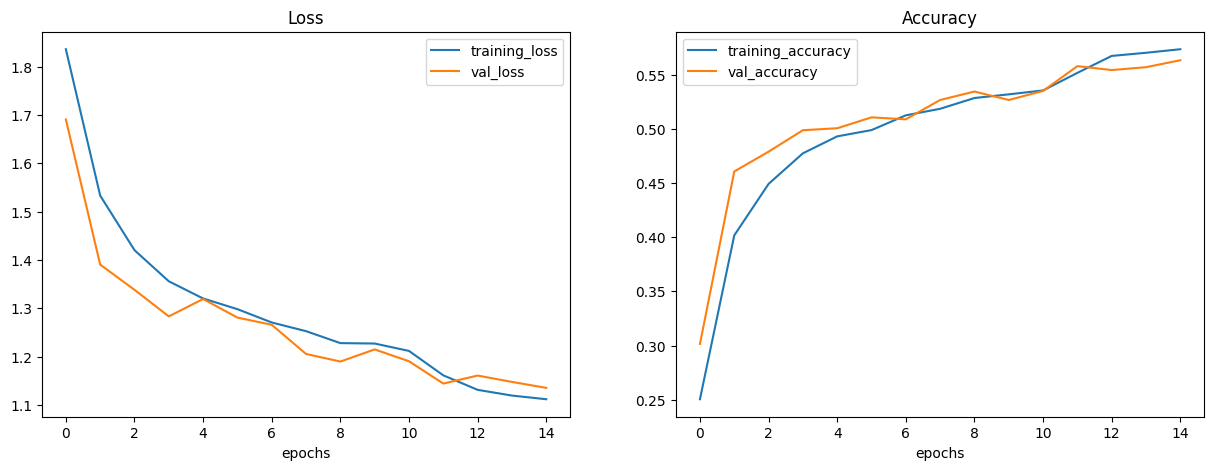

In [15]:
# Plotting training history
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(VGG16_history)


113/113 [==============================] - 35s 301ms/step


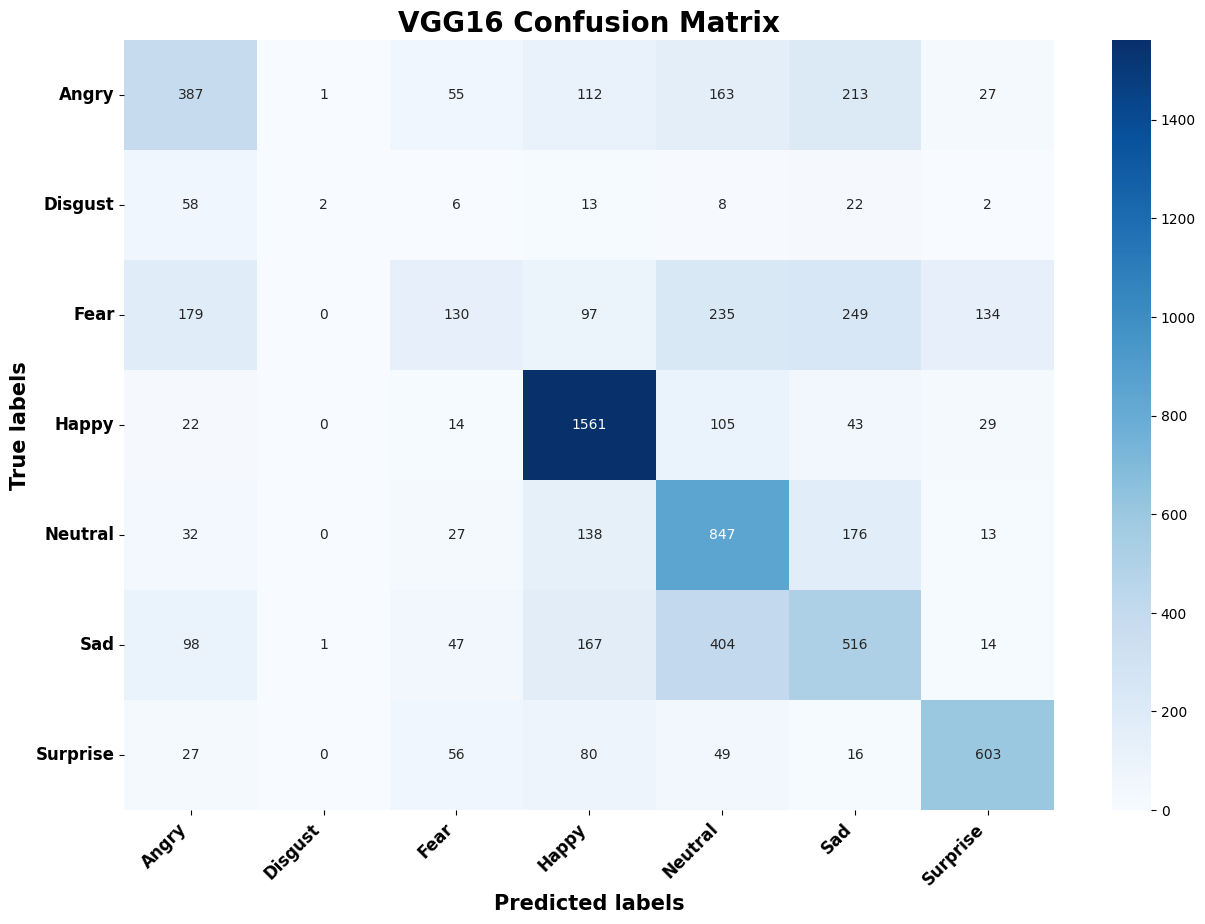

In [16]:
# Confusion matrix
CNN_Predictions = VGG16_Model.predict(test_data)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

cm = confusion_matrix(test_data.labels, CNN_Predictions)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('VGG16 Confusion Matrix', fontsize=20, fontweight='bold')
ax.set_xticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_yticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_xticklabels(Emotion_Classes, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(Emotion_Classes, rotation=0, fontsize=12, fontweight='bold')
plt.show()


Found 7178 images belonging to 7 classes.


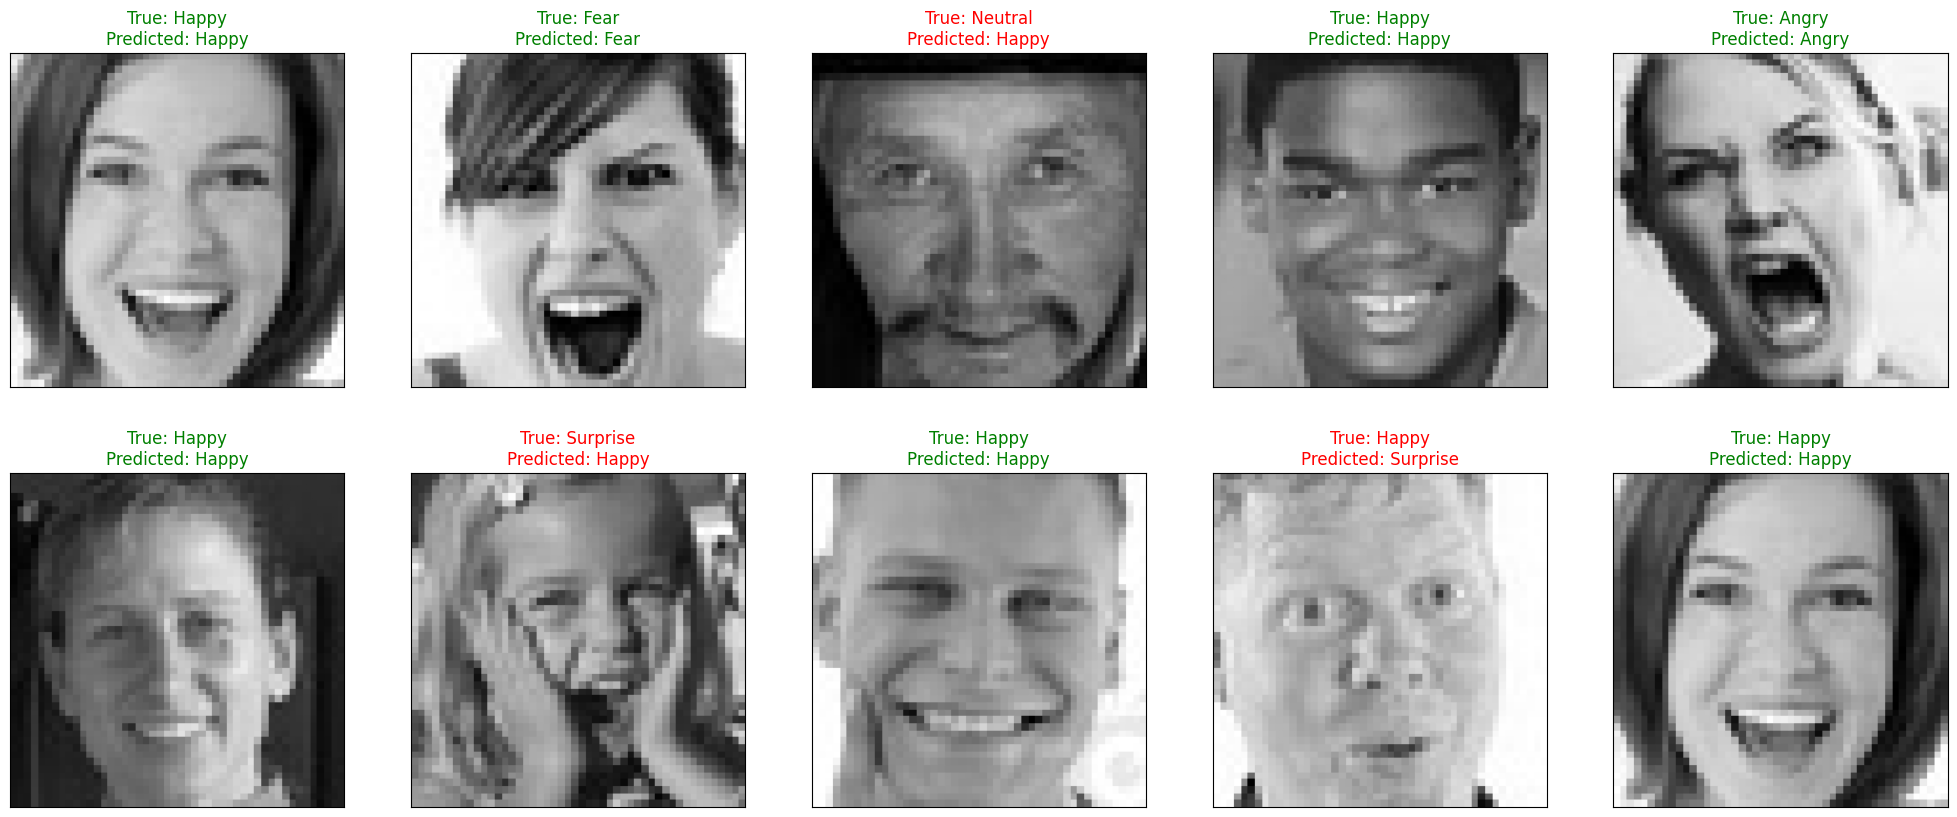

<Figure size 640x480 with 0 Axes>

In [17]:
# Displaying random test images with predictions
test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size
)

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(VGG16_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    ax.imshow(Random_Img)
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()
